In [ ]:
# 라이브러리 설치
!pip install torch torchvision torchaudio
!pip install torch-geometric

# 필요 라이브러리 임포트
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch.nn import LSTM, Linear
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch.nn.functional as F
import ast

import re  # Import the 're' module

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 데이터 경로 설정
base_path = '/content/drive/MyDrive/Graph LSTM/HDFS_v1/preprocessed/'

anomaly_label_path = base_path + 'anomaly_label.csv'
event_occurrence_matrix_path = base_path + 'Event_occurrence_matrix.csv'
log_templates_path = base_path + 'HDFS.log_templates.csv'
event_traces_path = base_path + 'Event_traces.csv'

# 데이터 로드
anomaly_label = pd.read_csv(anomaly_label_path)
event_occurrence_matrix = pd.read_csv(event_occurrence_matrix_path)
log_templates = pd.read_csv(log_templates_path)
event_traces = pd.read_csv(event_traces_path)
# 라벨 인코딩
label_dict = {'Normal': 0, 'Anomaly': 1}
anomaly_label['Label'] = anomaly_label['Label'].map(label_dict)

# 이벤트 ID 매핑
event_id_to_template = dict(zip(log_templates['EventId'], log_templates['EventTemplate']))
event_ids = log_templates['EventId'].unique()
event_id_to_index = {event_id: idx for idx, event_id in enumerate(event_ids)}

# 필요없는 열 제거
event_occurrence_matrix = event_occurrence_matrix.drop(columns=['Label', 'Type'])
event_occurrence_matrix = event_occurrence_matrix.fillna(0)

# 문자열 형태의 리스트를 실제 리스트로 변환
def parse_features(s):
    if not s or pd.isna(s):
        return []
    return re.findall(r'E\d+', s)

def parse_time_intervals(s):
    if not s or pd.isna(s):
        return []
    s = s.strip('[]')
    elements = s.split(',')
    elements = [float(e.strip()) for e in elements if e.strip()]
    return elements

event_traces['Features'] = event_traces['Features'].apply(parse_features)
event_traces['TimeInterval'] = event_traces['TimeInterval'].apply(parse_time_intervals)

# 'BlockId' 데이터 타입 통일
anomaly_label['BlockId'] = anomaly_label['BlockId'].astype(str)
event_traces['BlockId'] = event_traces['BlockId'].astype(str)

# 데이터 병합
merged_data = pd.merge(event_traces, anomaly_label.rename(columns={'Label': 'AnomalyLabel'}), on='BlockId', how='inner')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def create_graph(block_events):
    nodes = []
    edge_index = [[], []]

    # 이벤트 ID를 인덱스로 변환하여 노드 리스트 생성
    for event_id in event_ids:
        node_idx = event_id_to_index[event_id]
        nodes.append(node_idx)

    # 엣지 생성 (이벤트 시퀀스에 따라)
    for i in range(len(block_events) - 1):
        src = event_id_to_index[block_events[i]]
        dst = event_id_to_index[block_events[i + 1]]
        edge_index[0].append(src)
        edge_index[1].append(dst)

    # 텐서로 변환
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    x = torch.eye(len(event_ids))  # 노드 특징 (원-핫 인코딩)
    return x, edge_index


In [ ]:
graph_data_list = []

for idx, row in merged_data.iterrows():
    label = row['AnomalyLabel']
    events = row['Features']

    # 이벤트가 1개 이하인 경우 제외
    if len(events) <= 1:
        continue

    # 그래프 생성
    x, edge_index = create_graph(events)

    # 그래프 데이터 객체 생성
    data = Data(x=x, edge_index=edge_index, y=torch.tensor([label], dtype=torch.long))
    graph_data_list.append(data)


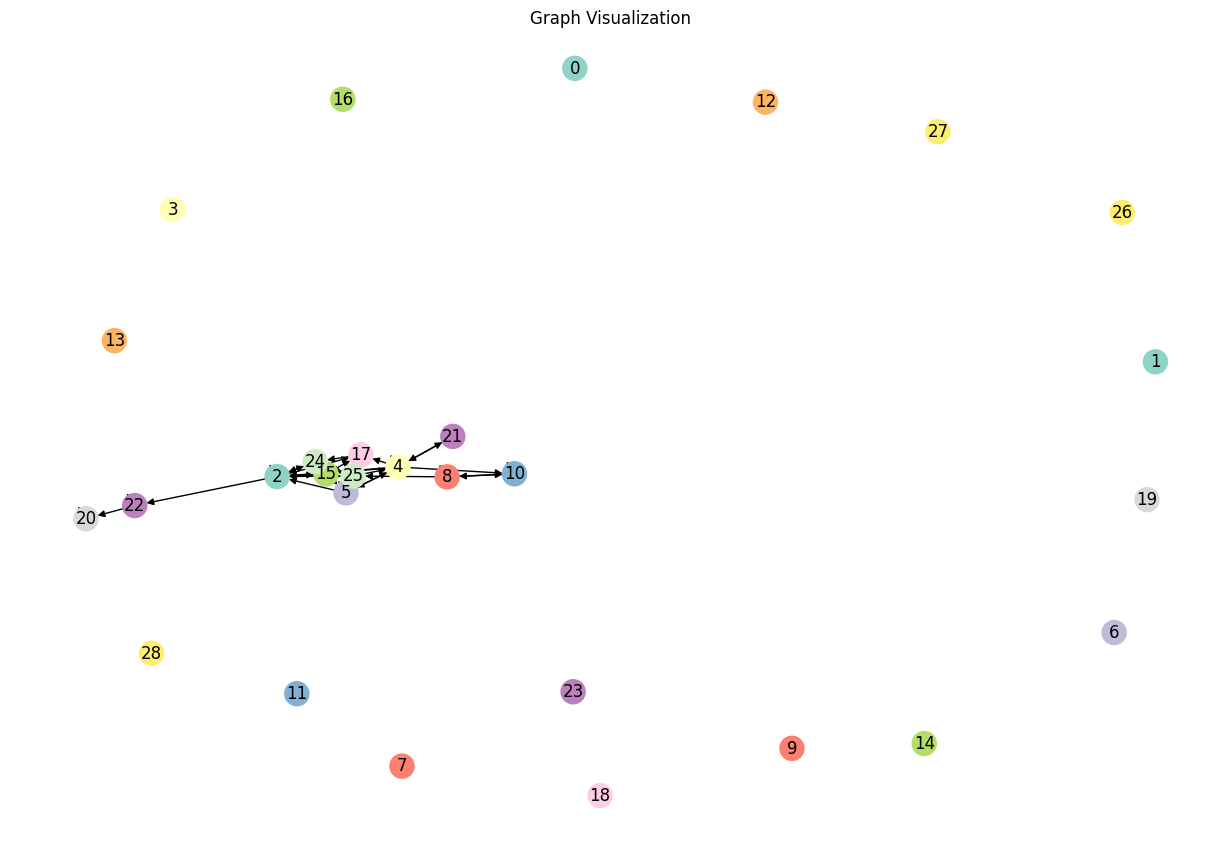

In [ ]:
import torch
import torch_geometric
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# 그래프 데이터 중 하나 선택
data = graph_data_list[0]

# NetworkX 그래프로 변환
G = to_networkx(data, node_attrs=['x'], edge_attrs=None)

# 그래프 레이아웃 설정
pos = nx.spring_layout(G, seed=42)

# 노드 특징에 따라 색상 지정
node_colors = [i for i in range(len(G.nodes()))]

# 그래프 그리기
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_color=node_colors, cmap=plt.cm.Set3)
plt.title('Graph Visualization')
plt.show()


In [ ]:
# 첫 번째 그래프 데이터가 어떤 BlockId에 해당하는지 확인
first_graph_index = 0  # 첫 번째 그래프의 인덱스
for idx, row in merged_data.iterrows():
    events = row['Features']
    if len(events) > 1:  # create_graph에서 사용된 필터 조건과 일치시킴
        if first_graph_index == 0:
            print(f"graph_data_list[0]에 해당하는 BlockId: {row['BlockId']}")
            break
        first_graph_index -= 1


graph_data_list[0]에 해당하는 BlockId: blk_-1608999687919862906


In [ ]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
import torch.nn as nn
from torch_geometric.nn import GCNConv, global_mean_pool

class GNN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, dropout=0.6):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.dropout2 = nn.Dropout(dropout)
        self.lin = Linear(hidden_channels, 2)  # 그래프 분류를 위한 출력 레이어
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, edge_index, batch): #이게 진짜임..우리는 이걸 쓰는거야. init는 디폴트 호출 때 사용되는 거다잉.
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.dropout2(x)
        x = global_mean_pool(x, batch)  # 그래프 임베딩 생성
        x = self.dropout3(x)
        x = self.lin(x)
        return x

    def get_node_embeddings(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.dropout2(x)
        return x  # 노드 임베딩 반환

print("GNN 모델 정의 완료.")

GNN 모델 정의 완료.


In [ ]:
from torch_geometric.loader import DataLoader

batch_size = 32

gnn_train_data, gnn_test_data = train_test_split(graph_data_list, test_size=0.2, random_state=42)

gnn_train_loader = DataLoader(gnn_train_data, batch_size=batch_size, shuffle=True)
gnn_test_loader = DataLoader(gnn_test_data, batch_size=batch_size, shuffle=False)

# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델 초기화
gnn_model = GNN(num_node_features=len(event_ids), hidden_channels=64, dropout=0.6).to(device)
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

# 학습 루프
num_epochs = 10
for epoch in range(num_epochs):
    gnn_model.train()
    total_loss = 0
    for data in gnn_train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = gnn_model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(gnn_train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')


Epoch [1/10], Loss: 0.1445
Epoch [2/10], Loss: 0.1288
Epoch [3/10], Loss: 0.1199
Epoch [4/10], Loss: 0.1098
Epoch [5/10], Loss: 0.1007
Epoch [6/10], Loss: 0.0918
Epoch [7/10], Loss: 0.0803
Epoch [8/10], Loss: 0.0705
Epoch [9/10], Loss: 0.0644
Epoch [10/10], Loss: 0.0595


In [ ]:
gnn_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in gnn_test_loader:
        data = data.to(device)
        out = gnn_model(data.x, data.edge_index, data.batch)
        _, pred = torch.max(out, 1)
        correct += (pred == data.y).sum().item()
        total += data.y.size(0)
accuracy = correct / total
print(f'GNN Test Accuracy: {accuracy:.4f}')


GNN Test Accuracy: 0.9880


In [ ]:
data_list = []

gnn_model.eval()

for idx, row in merged_data.iterrows():
    block_id = row['BlockId']
    label = row['AnomalyLabel']
    events = row['Features']

    # 이벤트가 1개 이하인 경우 제외
    if len(events) <= 1:
        continue

    # 그래프 생성
    x, edge_index = create_graph(events)
    x = x.to(device)
    edge_index = edge_index.to(device)

    with torch.no_grad():
        node_embeddings = gnn_model.get_node_embeddings(x, edge_index)  # 노드 임베딩 추출

    # 이벤트 시퀀스에 따른 임베딩 추출
    seq_embeddings = node_embeddings[[event_id_to_index[e] for e in events if e in event_id_to_index]]

    # 데이터 추가
    data_list.append((seq_embeddings.cpu().numpy(), label, block_id))


In [ ]:
print("Node Embeddings Shape:", node_embeddings.shape)
# 노드 인덱스와 이벤트 ID 매핑
index_to_event_id = {v: k for k, v in event_id_to_index.items()}

# 첫 번째 5개의 노드 임베딩 출력
for i in range(5):
    event_id = index_to_event_id[i]
    embedding = node_embeddings[i].cpu().numpy()
    print(f"Event ID: {event_id}, Embedding: {embedding}")
# 임베딩의 평균과 표준편차 계산
embeddings_np = node_embeddings.cpu().numpy()
mean = embeddings_np.mean()
std = embeddings_np.std()
print(f"Embeddings Mean: {mean:.4f}, Std: {std:.4f}")


Node Embeddings Shape: torch.Size([29, 64])
Event ID: E1, Embedding: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Event ID: E2, Embedding: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Event ID: E3, Embedding: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.02740759 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.   

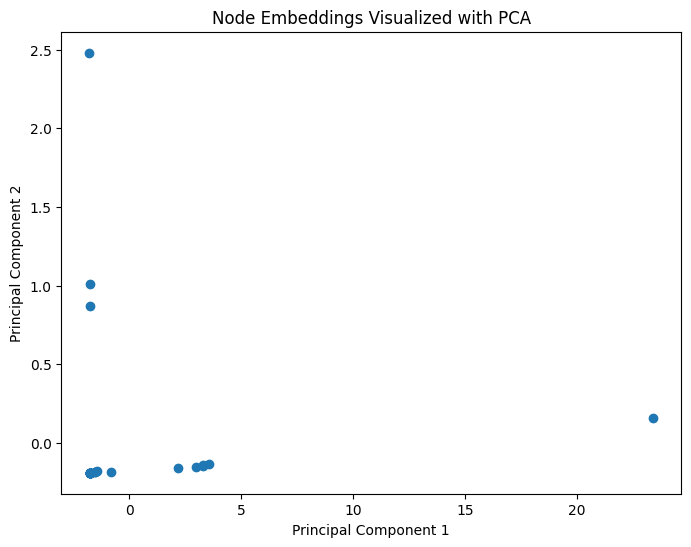

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 임베딩을 NumPy 배열로 변환
embeddings_np = node_embeddings.cpu().numpy()

# PCA로 2차원 축소
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_np)

# 이벤트 ID 라벨링
event_labels = [index_to_event_id[i] for i in range(len(embeddings_2d))]

# 시각화
plt.figure(figsize=(8,6))
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1])
plt.title('Node Embeddings Visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


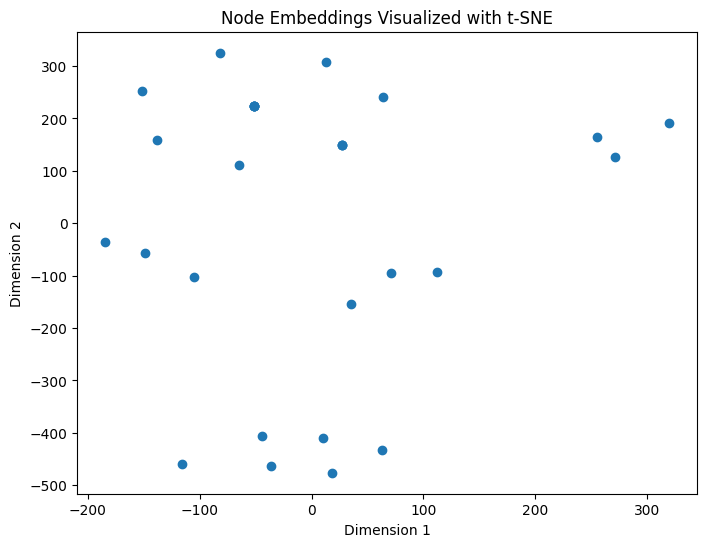

In [ ]:
from sklearn.manifold import TSNE

# t-SNE로 2차원 축소
tsne = TSNE(n_components=2, perplexity=5, n_iter=1000, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_np)

# 시각화
plt.figure(figsize=(8,6))
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1])
plt.title('Node Embeddings Visualized with t-SNE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


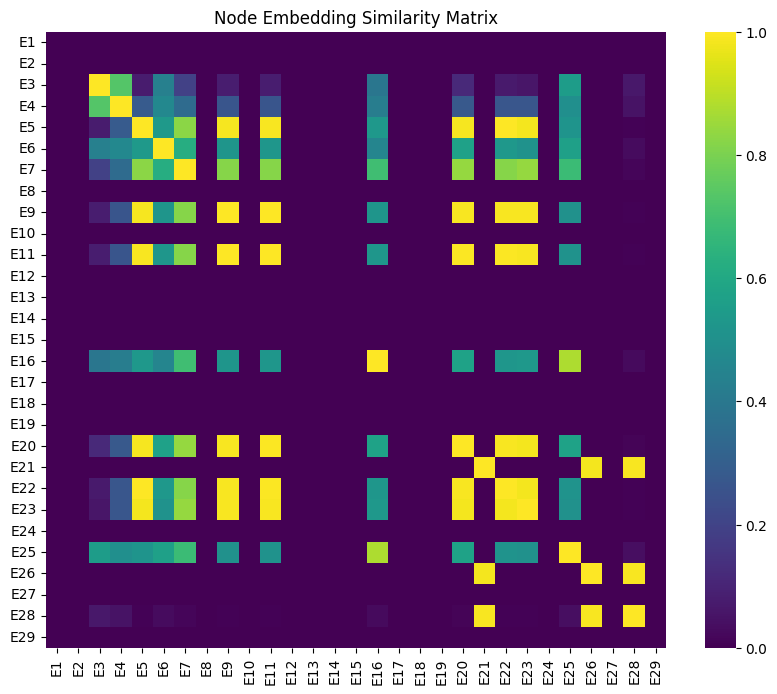

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

# 코사인 유사도 행렬 계산
similarity_matrix = cosine_similarity(embeddings_np)

# 시각화
plt.figure(figsize=(10,8))
sns.heatmap(similarity_matrix, xticklabels=event_labels, yticklabels=event_labels, cmap='viridis')
plt.title('Node Embedding Similarity Matrix')
plt.show()


In [ ]:
# 임베딩 저장
np.save('node_embeddings.npy', embeddings_np)

# 저장된 임베딩 불러오기
loaded_embeddings = np.load('node_embeddings.npy')


In [ ]:
for i in range(100) :
    # 첫 번째 블록의 임베딩 시퀀스 확인
    seq_embeddings, label, block_id = data_list[i]

    print(f"Block ID: {block_id}")
    print(f"Label: {label}")
    print("Sequence Embeddings Shape:", seq_embeddings.shape)
    print("Sequence Embeddings:")
    print(seq_embeddings)


Block ID: blk_-1608999687919862906
Label: 0
Sequence Embeddings Shape: (269, 64)
Sequence Embeddings:
[[0.         0.         0.         ... 0.1372109  0.16129917 0.        ]
 [0.         0.01826566 0.03019236 ... 0.         0.         0.00165817]
 [0.         0.         0.         ... 0.1372109  0.16129917 0.        ]
 ...
 [0.16510117 0.11790961 0.05436453 ... 0.         0.         0.06626518]
 [0.16510117 0.11790961 0.05436453 ... 0.         0.         0.06626518]
 [0.16510117 0.11790961 0.05436453 ... 0.         0.         0.06626518]]
Block ID: blk_7503483334202473044
Label: 0
Sequence Embeddings Shape: (22, 64)
Sequence Embeddings:
[[0.25905457 0.40750253 0.36278868 ... 0.         0.         0.34214997]
 [0.25905457 0.40750253 0.36278868 ... 0.         0.         0.34214997]
 [0.25905457 0.40750253 0.36278868 ... 0.         0.         0.34214997]
 ...
 [0.1699548  0.11130148 0.03415044 ... 0.         0.         0.05194454]
 [0.1699548  0.11130148 0.03415044 ... 0.         0.     

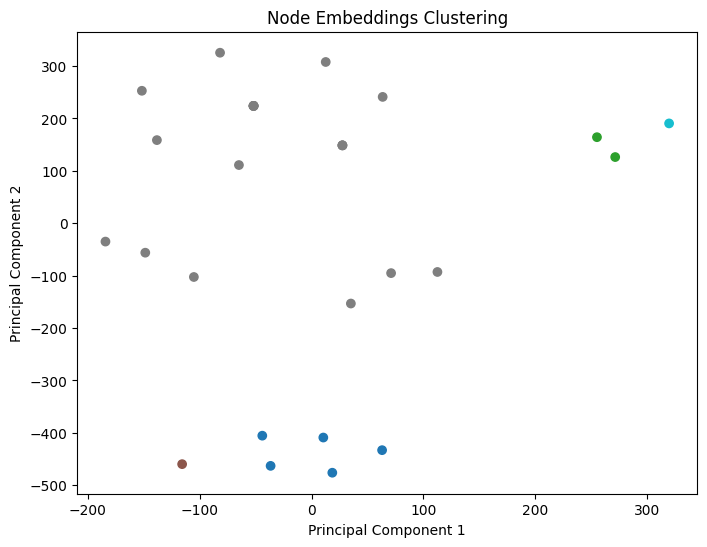

In [ ]:
from sklearn.cluster import KMeans

# 클러스터링 수행 (예: 5개 군집)
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(embeddings_np)

# 시각화 (PCA 적용 후 클러스터링 결과 표시)
plt.figure(figsize=(8,6))
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], c=clusters, cmap='tab10')
plt.title('Node Embeddings Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


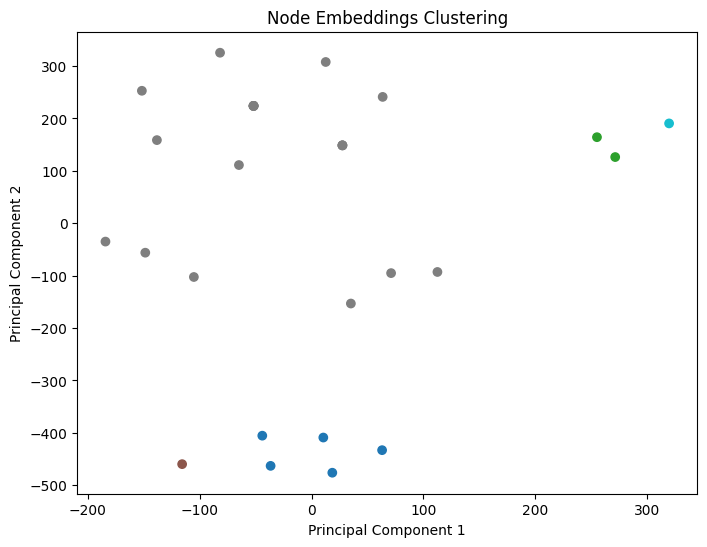

In [ ]:
from sklearn.cluster import KMeans

# 클러스터링 수행 (예: 5개 군집)
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(embeddings_np)

# 시각화 (PCA 적용 후 클러스터링 결과 표시)
plt.figure(figsize=(8,6))
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], c=clusters, cmap='tab10')
plt.title('Node Embeddings Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

# Dropout이 적용된 LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # LSTM 레이어에 Dropout 적용 (num_layers > 1일 때만 적용됨)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)
        # Fully Connected 레이어 전에 Dropout 추가
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # 초기 hidden 및 cell 상태 설정
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM 전방향 패스
        out, _ = self.lstm(x, (h0, c0))

        # Dropout 적용
        out = self.dropout(out)

        # 마지막 타임스텝의 출력값을 사용하여 분류
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
# 데이터 준비
inputs = []
labels = []
for seq_embeddings, label, block_id in data_list:
    inputs.append(seq_embeddings.mean(axis=0))  # 시퀀스 임베딩의 평균을 사용 (예시)
    labels.append(label)

inputs = torch.tensor(inputs, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.long)

# TensorDataset 생성 (inputs과 labels만 포함)
dataset = TensorDataset(inputs, labels)

# Train/Test Split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# DataLoader 설정
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
# LSTM 모델 초기화
input_size = inputs.shape[1]  # 노드 임베딩의 크기 (예: 64)
hidden_size = 128
num_layers = 2
num_classes = 2  # 정상, 비정상
dropout = 0.2  # Dropout 비율 설정

# lstm_model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
lstm_model = LSTMModel(input_size, hidden_size, num_layers, num_classes, dropout).to(device)
optimizer = optim.Adam(lstm_model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

# 학습 루프
num_epochs = 10
for epoch in range(num_epochs):
    lstm_model.train()
    total_loss = 0
    for batch_inputs, batch_labels in train_loader:
        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()
        outputs = lstm_model(batch_inputs.unsqueeze(1))  # LSTM은 (batch, seq, feature)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')


Epoch [1/10], Loss: 0.0509
Epoch [2/10], Loss: 0.0212
Epoch [3/10], Loss: 0.0197
Epoch [4/10], Loss: 0.0188
Epoch [5/10], Loss: 0.0180
Epoch [6/10], Loss: 0.0173
Epoch [7/10], Loss: 0.0159
Epoch [8/10], Loss: 0.0142
Epoch [9/10], Loss: 0.0131
Epoch [10/10], Loss: 0.0124


In [ ]:
# 모델 평가
lstm_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_inputs, batch_labels in test_loader:
        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)

        outputs = lstm_model(batch_inputs.unsqueeze(1))
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == batch_labels).sum().item()
        total += batch_labels.size(0)
accuracy = correct / total
print(f'LSTM Test Accuracy: {accuracy:.4f}')

LSTM Test Accuracy: 0.9958


Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    111682
     Anomaly       0.93      0.92      0.93      3331

    accuracy                           1.00    115013
   macro avg       0.97      0.96      0.96    115013
weighted avg       1.00      1.00      1.00    115013



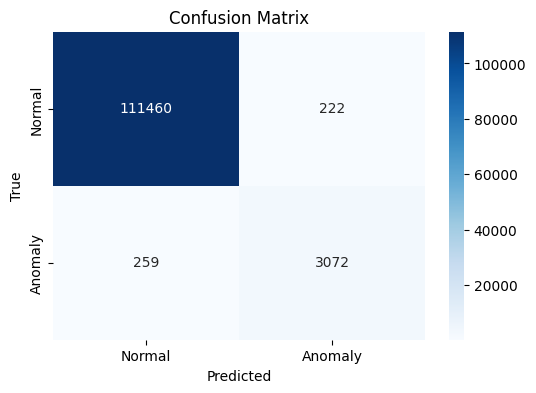

In [ ]:
# 모델 평가
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

lstm_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_inputs, batch_labels in test_loader:
        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)

        outputs = lstm_model(batch_inputs.unsqueeze(1))  # LSTM은 (batch, seq, feature)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

# 성능 평가
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Normal', 'Anomaly']))

# Confusion Matrix 생성
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
